<a href="https://colab.research.google.com/github/EricKenjiLee/WaveMAP_Paper/blob/main/WaveMAP_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import all packages and install packages not included in Colab


In [40]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from PIL import Image
from io import BytesIO
import base64

from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, ContinuousColorMapper
from bokeh.palettes import Turbo256
from bokeh.transform import linear_cmap
from bokeh.transform import factor_cmap


In [2]:
!pip install umap-learn==0.5.3
from umap import umap_ as umap

!pip install networkx==2.4
import networkx as nx

!pip install python-igraph==0.8.2
import igraph as ig

     |████████████████████████████████| 81kB 3.1MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.0-cp37-none-any.whl size=76337 sha256=db93e78cb06033b33ea530a85d808da3a3a19b3543bae6c900f695064d7a3611
  Stored in directory: /root/.cache/pip/wheels/c6/64/c4/6ff874f1bfedf37c36d1799b6f3da78c5bbcde007fbda096aa
Successfully built umap-learn
  Found existing installation: umap-learn 0.5.1
    Uninstalling umap-learn-0.5.1:
      Successfully uninstalled umap-learn-0.5.1
     |████████████████████████████████| 1.6MB 4.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5
     |████████████████████████████████| 3.2MB 5.5MB/s 


## ECG needs to be defined and added manually to iGraph

In [3]:
def community_ecg(self, weights=None, ens_size=16, min_weight=0.05):
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain 
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l[p[x.tuple[0]]]==l[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    part = self.community_multilevel(weights=w)
    part.W = w
    part.CSI = 1-2*np.sum([min(1-i,i) for i in w])/len(w)
    return part

ig.Graph.community_ecg = community_ecg

## Loading Fashion MNIST data

In [4]:
fmnist = datasets.fetch_openml('Fashion-MNIST')
np.random.shuffle(fmnist.data)
fmnist_subset = fmnist.data[:15000,:]

## Compute UMAP step of WaveMAP



In [5]:
reducer = umap.UMAP()
mapper = reducer.fit(fmnist_subset)
embedding = reducer.transform(fmnist_subset)

## Calculate ECG of UMAP high-dimensional graph

In [6]:
G = nx.from_scipy_sparse_matrix(mapper.graph_)
umap_igraph = ig.Graph(len(G), list(zip(*list(zip(*nx.to_edgelist(G)))[:2])))

umap_ECG = umap_igraph.community_ecg(ens_size=10,min_weight=0.5)

## Plot WaveMAP i.e. UMAP with ECG clusters

[]

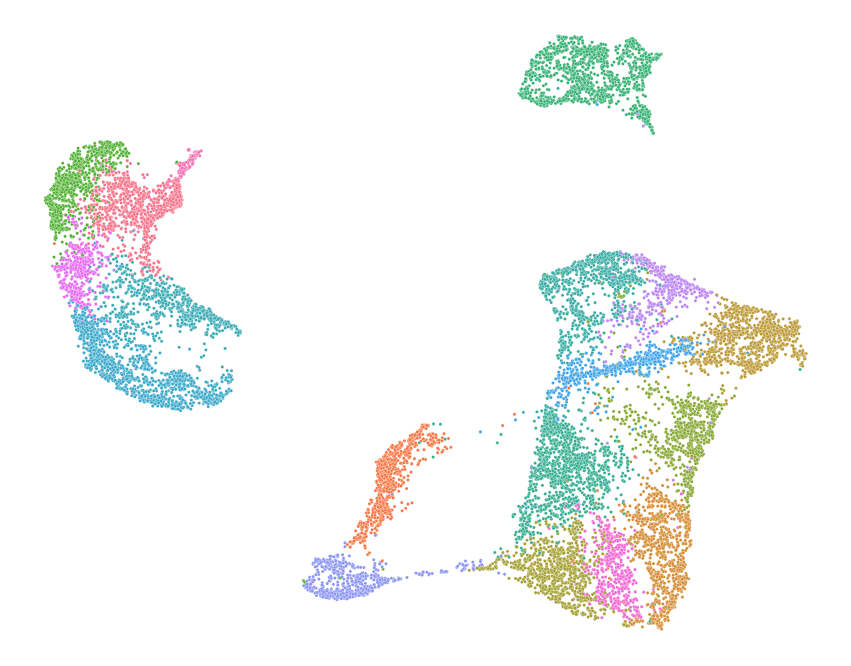

In [7]:
umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['color'] = umap_ECG.membership

ecg_colormap = [sns.color_palette("husl", len(set(umap_ECG.membership)))[i] for i in umap_ECG.membership]

f, arr = plt.subplots(1,figsize=[15,12])

arr.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(), 
            marker='o',c=ecg_colormap, s=10, edgecolor='w',
            linewidth=0.25)

arr.spines['top'].set_visible(False)
arr.spines['left'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.spines['bottom'].set_visible(False)

arr.set_xticks([])
arr.set_yticks([])

## Here we construct an interactive WaveMAP plot with Bokeh

In [9]:
def embeddable_image(data,color=None):
    fig, ax = plt.subplots()
    fig.set_figheight(0.5)
    fig.set_figwidth(0.5)
    ax.imshow(data.reshape(28,28))
    ax.axis('off')
    fig.canvas.draw()
    img_data = np.array(fig.canvas.renderer.buffer_rgba())
    image = Image.fromarray(img_data, mode='RGBA')
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    plt.close()
    
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()


def rgb2hex(rgb):
  rgb = tuple([int(x*256) for x in rgb])
  return '#%02x%02x%02x' % rgb

In [16]:
umap_df['data'] = list(fmnist_subset)
umap_df['image'] = list(map(embeddable_image, umap_df.data))
datasource = ColumnDataSource(umap_df)

plot_figure = figure(
    title='WaveMAP of dataset',
    plot_width=900,
    plot_height=900,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 12px; color: #224499'>Index:</span>
        <span style='font-size: 14px'>@index</span>
    </div>
</div>
"""))

  
n_clusts = len(umap_df['color'].unique())
color_map = factor_cmap(field_name='color', 
                       #palette=[rgb2hex(x) for x in list(sns.color_palette('husl',n_clusts))], 
                        palette = all_palettes['Category20c'][17],
                       factors=[str(x) for x in umap_df['color'].unique()] )

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4,
    color = color_map
)

output_file('WaveMAP_on_data.html')
show(plot_figure)

/usr/local/lib/python3.7/dist-packages/bokeh/models/mappers.py:147: UserWarning: Palette length does not match number of factors. ['17'] will be assigned to `nan_color` gray
  warnings.warn("Palette length does not match number of factors. %s will be assigned to `nan_color` %s" % (extra_factors, self.nan_color))


In [57]:
umap_df['data'] = list(fmnist_subset)
umap_df['image'] = list(map(embeddable_image, umap_df.data))
datasource = ColumnDataSource(umap_df)

plot_figure = figure(
    title='WaveMAP of dataset',
    plot_width=900,
    plot_height=900,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 12px; color: #224499'>Index:</span>
        <span style='font-size: 14px'>@index</span>
    </div>
</div>
"""))

color_ixs = np.round(np.linspace(0, len(Turbo256) - 1, len(umap_df['color'].unique()))).astype(int)
colors = [Turbo256[i] for i in color_ixs]
colormap = {i: colors[i] for i in umap_df['color'].unique()}
color_list = [colormap[x] for x in umap_df['color']]
umap_df['color_hex'] = color_list

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4,
    color = 'color_hex'
)

output_file('WaveMAP_on_data.html')
show(plot_figure)